## Environment Set-up

In [1]:
using_colab = True

In [ ]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything-2.git'

    !mkdir -p images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything-2/main/notebooks/images/truck.jpg
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything-2/main/notebooks/images/groceries.jpg

    !mkdir -p ../checkpoints/
    !wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt

## Set-up

In [3]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import plotly.express as px
import plotly.graph_objects as go

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

In [4]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cpu


In [5]:
np.random.seed(4)

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

# Seleccion box

In [6]:
sam2_checkpoint = "../checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)
predictor = SAM2ImagePredictor(sam2_model)


list_flower_info = [ {'flower_name': 'flower_DSC09069_JPG.jpg', 'boxes': [((1570, 1007), (3862, 3059))]},{'flower_name': 'flower_DSC09111_JPG.jpg', 'boxes': [((1976, 1602), (3977, 3409))]},{'flower_name': 'flower_DSC09101_JPG.jpg', 'boxes': [((2037, 1076), (4285, 3153))]},{'flower_name': 'flower_DSC09148.jpg', 'boxes': [((2089, 1250), (4472, 2766))]},{'flower_name': 'flower_DSC09028.jpg', 'boxes': [((2532, 1553), (3825, 2745))]},{'flower_name': 'flower_DSC09173_JPG.jpg', 'boxes': [((1533, 871), (4486, 2978))]},{'flower_name': 'flower_DSC09163_JPG.jpg', 'boxes': [((1090, 495), (4349, 3357))]},{'flower_name': 'flower_DSC09056_JPG.jpg', 'boxes': [((2105, 1431), (4694, 3445))]},{'flower_name': 'flower_DSC09046_JPG.jpg', 'boxes': [((1274, 719), (4422, 3834))]},{'flower_name': 'flower_DSC09187_JPG.jpg', 'boxes': [((1455, 1020), (4262, 3196))]},{'flower_name': 'flower_DSC09029.jpg', 'boxes': [((1081, 1904), (3007, 4369))]},{'flower_name': 'flower_DSC09161.jpg', 'boxes': [((1748, 1582), (3811, 3659))]},{'flower_name': 'flower_DSC09149.jpg', 'boxes': [((2335, 1371), (4516, 2927))]},{'flower_name': 'flower_DSC09034_JPG.jpg', 'boxes': [((1820, 1276), (4140, 2803))]},{'flower_name': 'flower_DSC_4531_JPG.jpg', 'boxes': [((2337, 1611), (3405, 2908))]},{'flower_name': 'flower_DSC_4428.jpg', 'boxes': [((1753, 763), (4213, 3067)), ((337, 2201), (1981, 3287))]},{'flower_name': 'flower_DSC09163.jpg', 'boxes': [((1100, 505), (4335, 3343))]},{'flower_name': 'flower_DSC09177.jpg', 'boxes': [((2047, 1070), (4507, 3333))]},{'flower_name': 'flower_DSC_4574.jpg', 'boxes': [((844, 585), (4263, 2955))]},{'flower_name': 'flower_DSC_4560.jpg', 'boxes': [((1597, 507), (4353, 2808))]},{'flower_name': 'flower_DSC09017.jpg', 'boxes': [((1493, 369), (4391, 3367))]},{'flower_name': 'flower_DSC09070_JPG.jpg', 'boxes': [((1273, 1075), (3476, 3076)), ((445, 3444), (1198, 3999))]},{'flower_name': 'flower_DSC09108_JPG.jpg', 'boxes': [((1936, 1484), (3483, 2650))]},{'flower_name': 'flower_DSC09060_JPG.jpg', 'boxes': [((1959, 1764), (4109, 3729))]},{'flower_name': 'flower_DSC_4565_JPG.jpg', 'boxes': [((1788, 920), (3902, 2623))]},{'flower_name': 'flower_DSC09094_JPG.jpg', 'boxes': [((639, 888), (4272, 3886))]},{'flower_name': 'flower_DSC09084_JPG.jpg', 'boxes': [((1598, 1042), (3817, 2823))]},{'flower_name': 'flower_DSC09016.jpg', 'boxes': [((2138, 311), (4644, 3362))]},{'flower_name': 'flower_DSC09155_JPG.jpg', 'boxes': [((1355, 874), (4885, 3278))]},{'flower_name': 'flower_DSC_4561.jpg', 'boxes': [((1691, 430), (4465, 2736))]},{'flower_name': 'flower_DSC_4528_JPG.jpg', 'boxes': [((2353, 1192), (3248, 2642))]},{'flower_name': 'flower_DSC09176.jpg', 'boxes': [((1959, 1196), (4618, 3209))]},{'flower_name': 'flower_DSC_4432_JPG.jpg', 'boxes': [((1642, 645), (3861, 2849))]},{'flower_name': 'flower_DSC09162.jpg', 'boxes': [((1758, 1288), (3878, 2720))]},{'flower_name': 'flower_DSC09137_JPG.jpg', 'boxes': [((1601, 1291), (3386, 3267)), ((3576, 2289), (4726, 3414))]},{'flower_name': 'flower_DSC09172.jpg', 'boxes': [((1633, 1208), (4255, 3055))]},{'flower_name': 'flower_DSC_4571.jpg', 'boxes': [((312, 1665), (1918, 3033)), ((2348, 1390), (3402, 2265)), ((3276, 2049), (4192, 3219))]},{'flower_name': 'flower_DSC09061_JPG.jpg', 'boxes': [((1702, 1573), (3760, 3812))]},{'flower_name': 'flower_DSC09109_JPG.jpg', 'boxes': [((1653, 1207), (4051, 3387))]},{'flower_name': 'flower_DSC_4565.jpg', 'boxes': [((1801, 909), (3912, 2597))]},{'flower_name': 'flower_DSC09071_JPG.jpg', 'boxes': [((1979, 33), (4064, 2141))]},{'flower_name': 'flower_DSC_4574_JPG.jpg', 'boxes': [((820, 1355), (1965, 2556)), ((2694, 604), (3720, 1544)), ((3166, 1753), (4237, 2945))]},{'flower_name': 'flower_DSC09144_JPG.jpg', 'boxes': [((1491, 934), (4832, 2933))]},{'flower_name': 'flower_DSC09085_JPG.jpg', 'boxes': [((1500, 928), (3966, 2708))]},{'flower_name': 'flower_DSC09095_JPG.jpg', 'boxes': [((13, 826), (1348, 2047)), ((596, 989), (4141, 3896))]},{'flower_name': 'flower_DSC_4570.jpg', 'boxes': [((1439, 784), (4332, 2342)), ((1493, 2163), (2334, 2807)), ((5009, 2082), (5009, 2082))]},{'flower_name': 'flower_DSC09173.jpg', 'boxes': [((1521, 905), (4462, 2965))]},{'flower_name': 'flower_DSC09136_JPG.jpg', 'boxes': [((2048, 1545), (2850, 2204)), ((2070, 1575), (4277, 3076))]},{'flower_name': 'flower_DSC09100_JPG.jpg', 'boxes': [((1873, 1043), (4027, 2838))]},{'flower_name': 'flower_DSC09078_JPG.jpg', 'boxes': [((1739, 766), (4209, 3188))]},{'flower_name': 'flower_DSC09110_JPG.jpg', 'boxes': [((2100, 1104), (4754, 3371))]},{'flower_name': 'flower_DSC09068_JPG.jpg', 'boxes': [((2255, 701), (4122, 2975)), ((1733, 2185), (2232, 2979))]},{'flower_name': 'flower_DSC09171.jpg', 'boxes': [((745, 839), (1674, 2348)), ((1377, 119), (4284, 3197))]},{'flower_name': 'flower_DSC_4566.jpg', 'boxes': [((2038, 995), (4162, 2621))]},{'flower_name': 'flower_DSC09039.jpg', 'boxes': [((1312, 1880), (2067, 2533)), ((2923, 1979), (3592, 2679)), ((2072, 2623), (3599, 3484)), ((1293, 490), (3378, 2199))]},{'flower_name': 'flower_DSC09162_JPG.jpg', 'boxes': [((1734, 1271), (3846, 2702))]},{'flower_name': 'flower_DSC09172_JPG.jpg', 'boxes': [((1614, 1198), (4143, 3040))]},{'flower_name': 'flower_DSC09186_JPG.jpg', 'boxes': [((1150, 1009), (4150, 3036))]},{'flower_name': 'flower_DSC09038.jpg', 'boxes': [((1506, 976), (3468, 3650))]},{'flower_name': 'flower_DSC_4573.jpg', 'boxes': [((805, 1085), (2384, 2294)), ((2628, 237), (3590, 1162)), ((2708, 1374), (3931, 2570))]},{'flower_name': 'flower_DSC09047_JPG.jpg', 'boxes': [((1173, 463), (4613, 3469))]},{'flower_name': 'flower_DSC09057_JPG.jpg', 'boxes': [((2188, 327), (4282, 2500)), ((1832, 2403), (2910, 3796))]},{'flower_name': 'flower_DSC09158.jpg', 'boxes': [((1852, 1069), (4569, 3336)), ((822, 2002), (0, 1162))]},{'flower_name': 'flower_DSC09025_JPG.jpg', 'boxes': [((2165, 1583), (3746, 2834))]},{'flower_name': 'flower_DSC09035_JPG.jpg', 'boxes': [((1809, 771), (4307, 2731))]},{'flower_name': 'flower_DSC09164.jpg', 'boxes': [((1025, 764), (4655, 3672))]},{'flower_name': 'flower_DSC09170.jpg', 'boxes': [((1633, 920), (4041, 2919))]},{'flower_name': 'flower_DSC_4458_JPG.jpg', 'boxes': [((1804, 1161), (3618, 2435))]},{'flower_name': 'flower_DSC_4566_JPG.jpg', 'boxes': [((2013, 977), (4157, 2611))]},{'flower_name': 'flower_DSC09073_JPG.jpg', 'boxes': [((498, 1360), (3501, 4397))]},{'flower_name': 'flower_DSC09063_JPG.jpg', 'boxes': [((2195, 1338), (4148, 2695))]},{'flower_name': 'flower_DSC_4474.jpg', 'boxes': [((2313, 862), (3684, 2337)), ((3098, 2472), (4195, 3189))]},{'flower_name': 'flower_DSC_4528.jpg', 'boxes': [((2366, 1191), (3266, 2534)), ((2890, 2142), (3255, 2517))]},{'flower_name': 'flower_DSC09063.jpg', 'boxes': [((2211, 1387), (4141, 2696))]},{'flower_name': 'flower_DSC09179_JPG.jpg', 'boxes': [((1617, 550), (4380, 2894)), ((2120, 0), (2120, 0))]},{'flower_name': 'flower_DSC_4488_JPG.jpg', 'boxes': [((370, 2101), (2433, 3927)), ((2366, 2707), (4064, 1027))]},{'flower_name': 'flower_DSC09134_JPG.jpg', 'boxes': [((2066, 1608), (4023, 2896))]},{'flower_name': 'flower_DSC09076.jpg', 'boxes': [((1997, 1177), (4026, 3252))]},{'flower_name': 'flower_DSC09124_JPG.jpg', 'boxes': [((2347, 1655), (3833, 2977))]},{'flower_name': 'flower_DSC09116.jpg', 'boxes': [((1940, 1502), (3547, 2777)), ((3522, 1249), (4850, 2307))]},{'flower_name': 'flower_DSC_4461.jpg', 'boxes': [((2089, 197), (4393, 2684)), ((2636, 2657), (3914, 3382))]},{'flower_name': 'flower_DSC09156_JPG.jpg', 'boxes': [((1433, 977), (2825, 2481)), ((2693, 961), (3496, 1713)), ((2941, 1279), (4843, 2987)), ((4042, 2591), (5157, 3586))]},{'flower_name': 'flower_DSC_4475.jpg', 'boxes': [((2188, 964), (3445, 2393)), ((3108, 2259), (4155, 3183))]},{'flower_name': 'flower_DSC09097_JPG.jpg', 'boxes': [((1563, 1295), (3573, 3660))]},{'flower_name': 'flower_DSC09087_JPG.jpg', 'boxes': [((1661, 1233), (4377, 3999))]},{'flower_name': 'flower_DSC09170_JPG.jpg', 'boxes': [((1610, 937), (4028, 2914))]},{'flower_name': 'flower_DSC09018_JPG.jpg', 'boxes': [((451, 629), (1838, 2866)), ((1971, 449), (3004, 1730)), ((1829, 1434), (4296, 3106))]},{'flower_name': 'flower_DSC09128.jpg', 'boxes': [((1734, 1089), (3903, 2867))]},{'flower_name': 'flower_DSC09100.jpg', 'boxes': [((1877, 1040), (4045, 2875))]},{'flower_name': 'flower_DSC_4488.jpg', 'boxes': [((2308, 1036), (4091, 2683)), ((408, 2117), (1315, 3418)), ((1173, 2331), (2457, 3931))]},{'flower_name': 'flower_DSC_4475_JPG.jpg', 'boxes': [((2195, 924), (3437, 2383)), ((3100, 2236), (4130, 3172))]},{'flower_name': 'flower_DSC09114.jpg', 'boxes': [((1906, 1051), (3831, 2689))]},{'flower_name': 'flower_DSC09112_JPG.jpg', 'boxes': [((2035, 1028), (4200, 2977))]},{'flower_name': 'flower_DSC09048.jpg', 'boxes': [((1930, 1156), (4300, 2961))]},{'flower_name': 'flower_DSC09074.jpg', 'boxes': [((249, 1621), (1422, 3283)), ((795, 2572), (3287, 4533))]},{'flower_name': 'flower_DSC09060.jpg', 'boxes': [((1936, 1765), (4112, 3734))]},{'flower_name': 'flower_DSC_4532_JPG.jpg', 'boxes': [((2400, 1272), (3349, 2478))]},{'flower_name': 'flower_DSC09037_JPG.jpg', 'boxes': [((1543, 612), (4617, 2896)), ((4061, 2157), (4997, 3020))]},{'flower_name': 'flower_DSC09027_JPG.jpg', 'boxes': [((2370, 1373), (3703, 2565))]},{'flower_name': 'flower_DSC09061.jpg', 'boxes': [((1697, 1566), (3708, 3817))]},{'flower_name': 'flower_DSC09075.jpg', 'boxes': [((1195, 2142), (3316, 4304))]},{'flower_name': 'flower_DSC09049.jpg', 'boxes': [((4201, 2967), (1547, 986))]},{'flower_name': 'flower_DSC_4489.jpg', 'boxes': [((1485, 1165), (3444, 2851)), ((3189, 1717), (4762, 229))]},{'flower_name': 'flower_DSC09115.jpg', 'boxes': [((1759, 2698), (3386, 1303))]},{'flower_name': 'flower_DSC09101.jpg', 'boxes': [((2024, 1053), (4281, 2928)), ((4043, 1255), (5631, 2476))]},{'flower_name': 'flower_DSC09129.jpg', 'boxes': [((1553, 1267), (3685, 3083)), ((3958, 1788), (4928, 3109))]},{'flower_name': 'flower_DSC09184_JPG.jpg', 'boxes': [((1415, 3201), (3934, 1018))]},{'flower_name': 'flower_DSC_4462.jpg', 'boxes': [((2655, 3416), (3985, 2693)), ((2015, 2683), (4727, 49))]} ]

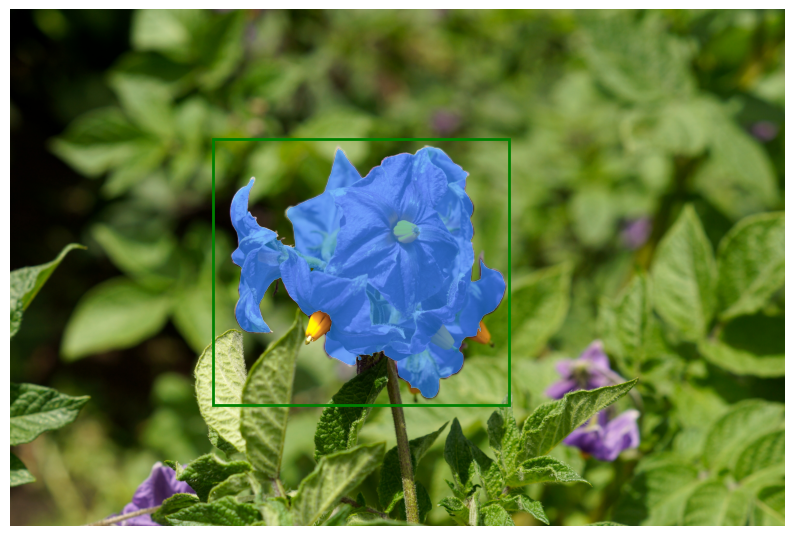

In [7]:
calibrated_image_directory = "/content/drive/MyDrive/Universidad/MIA/Tesis/Proyecto/Imagenes/calibrated"

for flower in list_flower_info:
  image1 = Image.open(f'{calibrated_image_directory}/{flower["flower_name"]}')
  image1 = np.array(image1.convert("RGB"))

  image1_boxes = np.array(flower["boxes"])
  image1_boxes = image1_boxes.reshape(image1_boxes.shape[0], 4)

  predictor.set_image(image1)

  if image1_boxes.shape[0] > 1:
    masks, scores, _ = predictor.predict(
        point_coords=None,
        point_labels=None,
        box=image1_boxes,
        multimask_output=False,
    )
    for mask in masks:
        show_mask(mask.squeeze(0), plt.gca(), random_color=True)
    for box in image1_boxes:
        show_box(box, plt.gca())
  else:
    image1_boxes = image1_boxes[0]
    masks, scores, _ = predictor.predict(
        point_coords=None,
        point_labels=None,
        box=image1_boxes[None, :],
        multimask_output=False,
    )
    show_masks(image1, masks, scores, box_coords=image1_boxes)

  break
